In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
 #Loading the Dataset
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/italy/merged_final.csv')
real_ICU_access=dataset.iloc[lambda x: x.index % 4 == 0, 11].values
real_ICU_access=real_ICU_access[2:]
data_test=dataset.iloc[lambda x: x.index % 4 == 0,[3,4,5,6,11,12]].values
training_set=dataset.iloc[lambda x: x.index % 4 != 0,[3,4,5,6,11,12]].values
 #Features Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
 #Creating Data with Timesteps
X_train = []
y_train = []
for i in range(2, len(training_set)):
    X_train.append(training_set_scaled[i-2:i,:])
    y_train.append(training_set_scaled[i, 4])
X_train, y_train = np.array(X_train), np.array(y_train)
 #Creating Data with Timesteps
inputs = sc.transform(data_test)
X_test = []
Y_test=[]
for i in range(2,len(data_test)):
    X_test.append(inputs[i-2:i,:])
    Y_test.append(inputs[i,4])
X_test,Y_test = np.array(X_test),np.array(Y_test)

In [ ]:
#Building the LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from tensorflow import keras

regressor = Sequential()

regressor.add(LSTM(units = 128, return_sequences = False, input_shape = (X_train.shape[1], X_train.shape[2]))) #units multipli di 4, provare con 4,8,16,32
regressor.add(Dropout(0.1)) 

regressor.add(Dense(units = 1,activation='linear'))
regressor.summary()
opt = keras.optimizers.Adam(learning_rate=0.02)
regressor.compile(optimizer = opt , loss = 'mean_squared_error')

history=regressor.fit(X_train, y_train,validation_data=(X_test,Y_test), epochs = 512, batch_size = 4)

In [ ]:
from keras.models import load_model
regressor=load_model('/content/drive/MyDrive/Colab Notebooks/lstm_model_ratio5input_3train1test_2layer_units32_dropout0,1.h5')

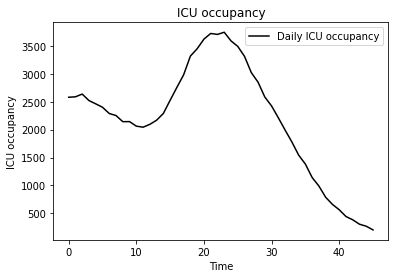

In [ ]:
#Make prediction
predicted_ICU_accesses = regressor.predict(X_test)
result=predicted_ICU_accesses.flatten()
matrix_result=np.array([])
for i in range(len(result)):
  row=np.array([])
  for j in range(6):
    row=np.append(row,result[i])
  matrix_result=np.append(matrix_result,row)  
matrix_result=np.reshape(matrix_result,(-1,6))
predicted_ICU_accesses = sc.inverse_transform(matrix_result)
print(predicted_ICU_accesses[:,4].shape)
#Plotting the results
plt.plot(real_ICU_access, color = 'black', label = 'Daily ICU occupancy')
#plt.plot(predicted_ICU_accesses[:,4], color = 'green', label = 'Daily predicted ICU occupancy')
plt.title('ICU occupancy')
plt.xlabel('Time')
plt.ylabel('ICU occupancy')
plt.legend()
plt.show()

# Save

In [ ]:
regressor.save('/content/drive/MyDrive/Colab Notebooks/lstm_model_ratio5input_3train1test_02/09/21.h5')

# **RMSE**

In [ ]:
#RMSE
import numpy
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
testScore = math.sqrt(mean_squared_error(real_ICU_access, predicted_ICU_accesses[:,4]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 111.68 RMSE


# **Evaluate model**

Train: 0.0001 Test: 0.0010


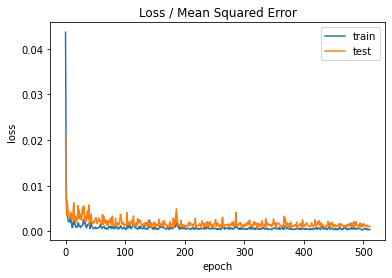

In [ ]:
#Evaluate model
from matplotlib import pyplot
train_mse = regressor.evaluate(X_train, y_train, verbose=0)
test_mse= regressor.evaluate(X_test,Y_test,verbose=0)
print('Train: %.4f Test: %.4f'%(train_mse,test_mse))
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.xlabel('epoch')
pyplot.ylabel('loss')
pyplot.legend()
pyplot.show()